In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

%run ../Scripts/analysisMethods.py
foldername = "../Data_temp_name10/beta-0.01_seed0"

Missing folder


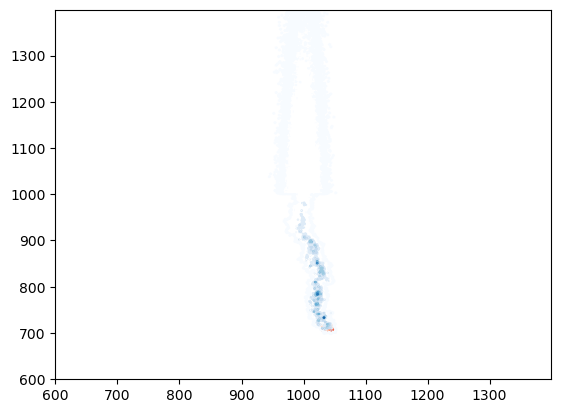

In [2]:
t_dom, foldername, margins = get_tdomain_and_show_last_output(foldername, margins = (-0.3, -0.3), dt = 10)

In [3]:
t_domain_no_error = []
for t in t_dom:
    try:
        n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
        indexes = get_nonzero_w_repeats(n_i)
        means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes,n_components=1, 
                                                        w = 1000, reg_covar=1e8)
        means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)

        next_list = make_Treelist(t, means, covs, counts)

        if t == t_dom[0]:
            init_list = next_list
            prev_list = next_list
            continue

        prev_list = link_Treelists(prev_list, next_list)
        prev_list = next_list
        plot_Ellipses(n_i, t, means, covs, save = True,
                    foldername = foldername, input_color = "teal", margins=margins)
        
        t_domain_no_error.append(t)

        plt.close('all')
    except ValueError:
        print(t)
        break
else:
    make_Gif(foldername, t_domain_no_error, typename = "GMM_plots")
    save_Treelist(foldername, init_list)
    print("GMM plots made")

GMM plots made


: 

In [51]:
%run ../Scripts/trajectoryVisual.py
color ="teal"
v, w = np.linalg.eigh(covs)
v = v.squeeze(); w = w.squeeze()
u = w[0] / np.linalg.norm(w[0])
angle = np.arctan2(u[1], u[0])
angle = 180+180 * angle / np.pi  # convert to degrees
v = (2.0 * np.sqrt(2.0) * np.sqrt(v)).squeeze()
ell = mpl.patches.Ellipse(means, v[0], v[1], angle = 180)

# make_ellipse(means, covs, color = "teal")

time plots made


/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/trajectoryVisual.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


FileNotFoundError: The directory '/Users/zhizhang144515/Documents/CRISPR_Sim/Data_temp_name10/beta-0.01_seed0/GMM_plots' does not exist

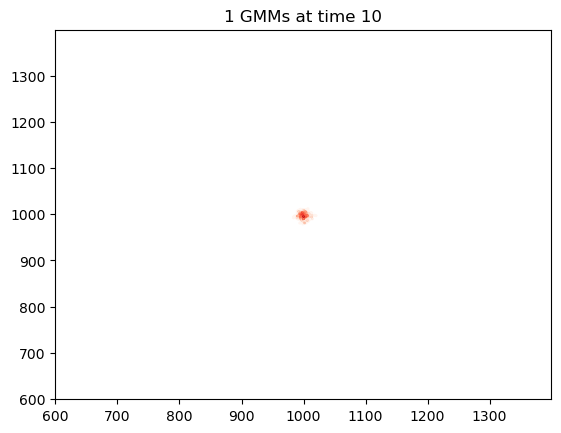

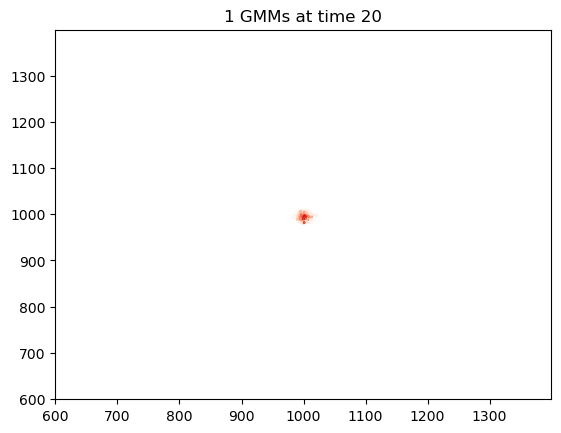

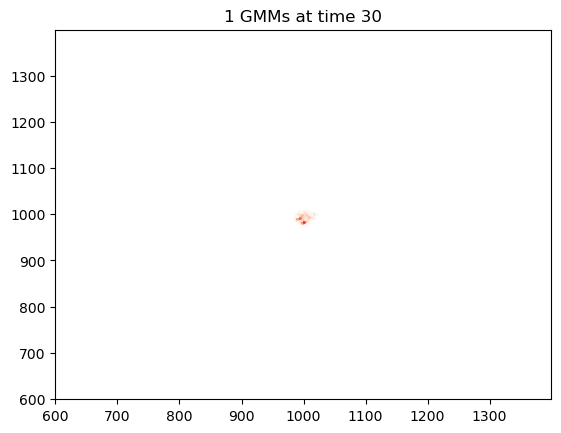

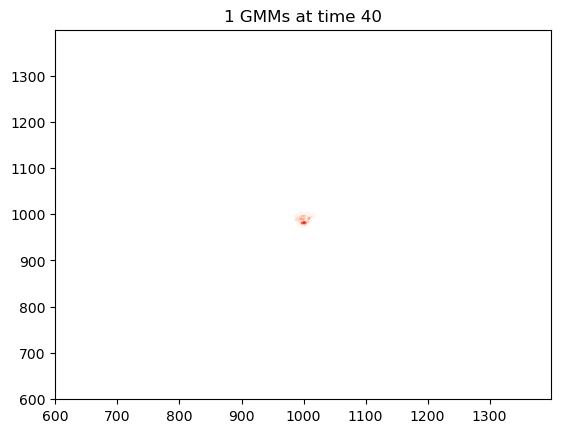

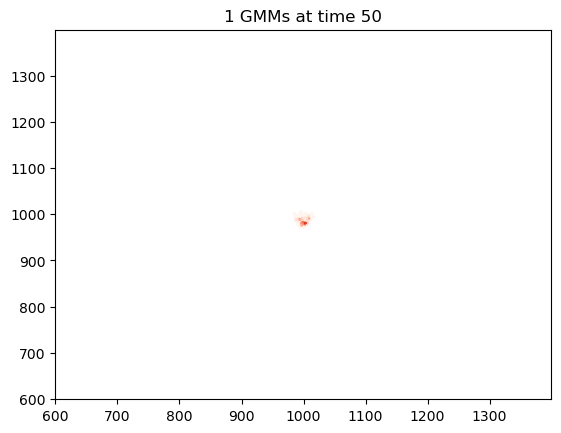

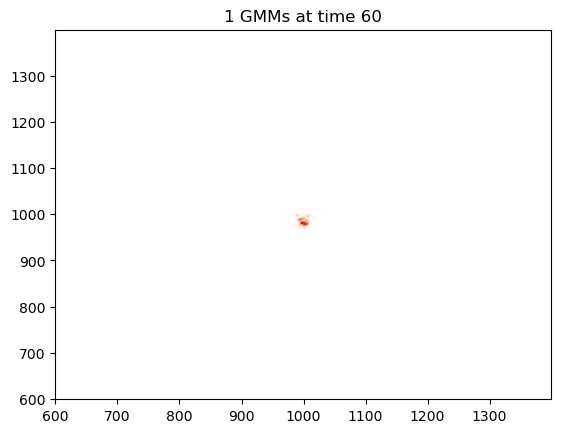

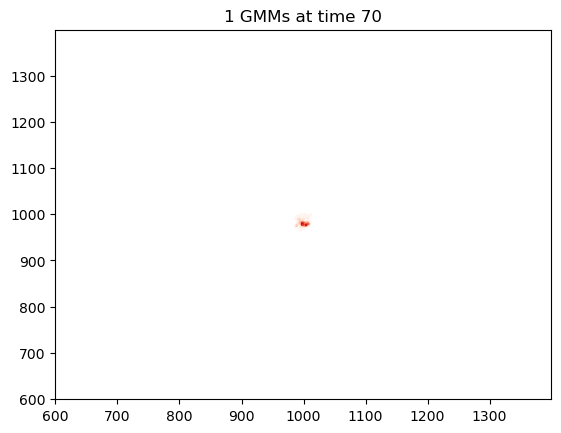

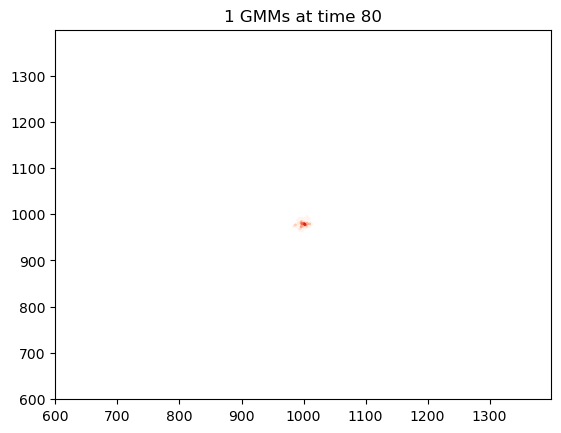

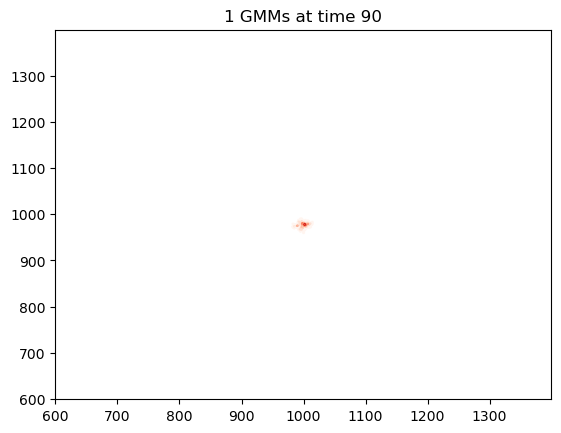

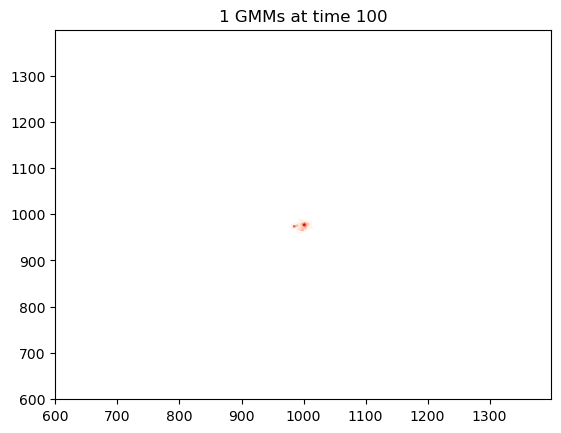

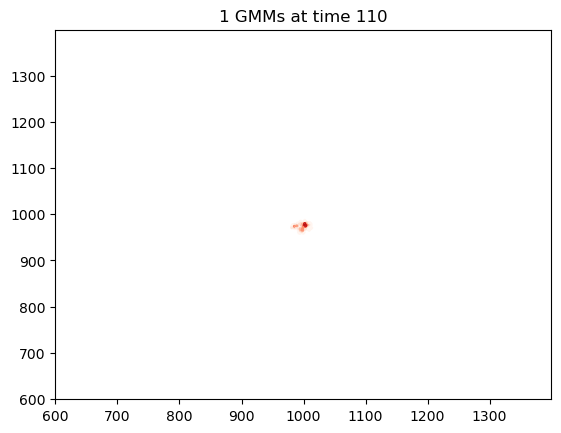

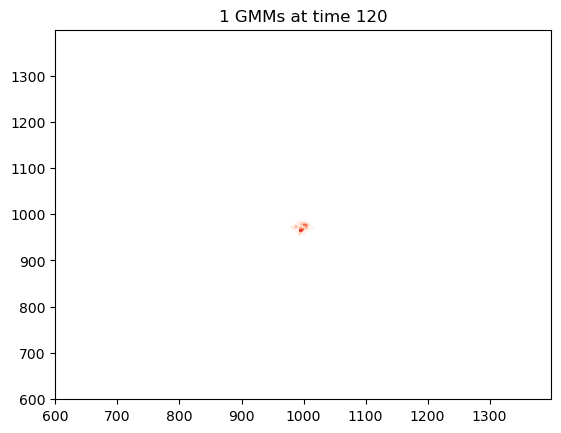

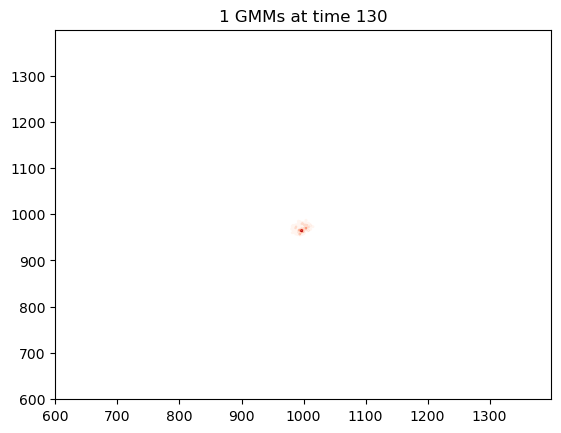

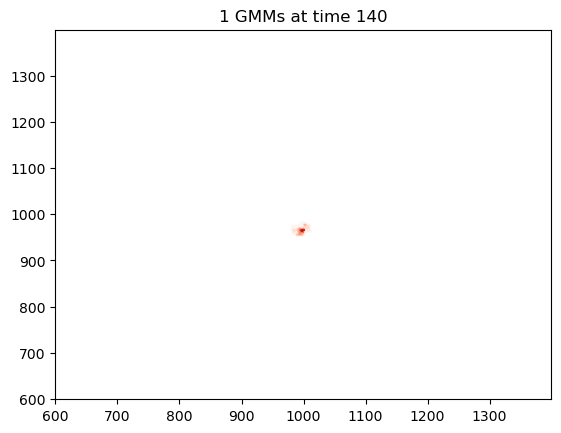

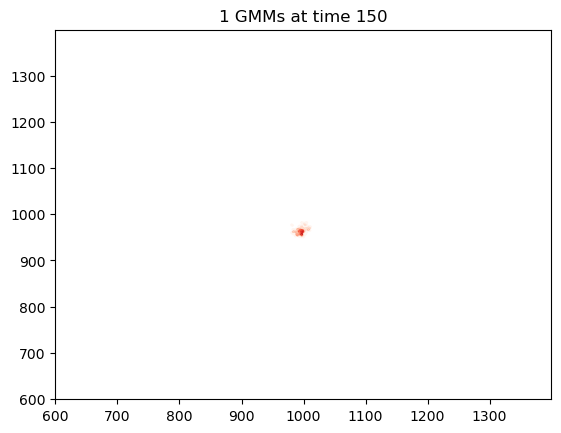

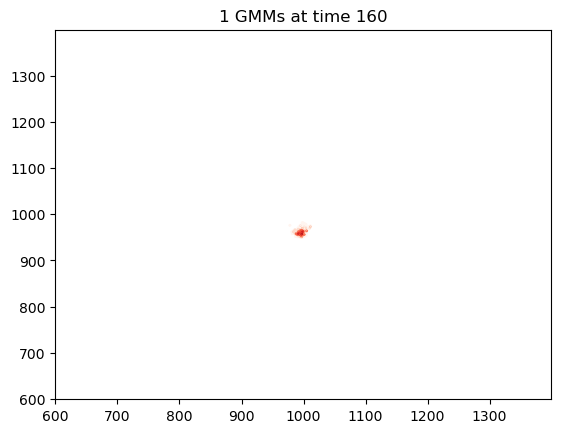

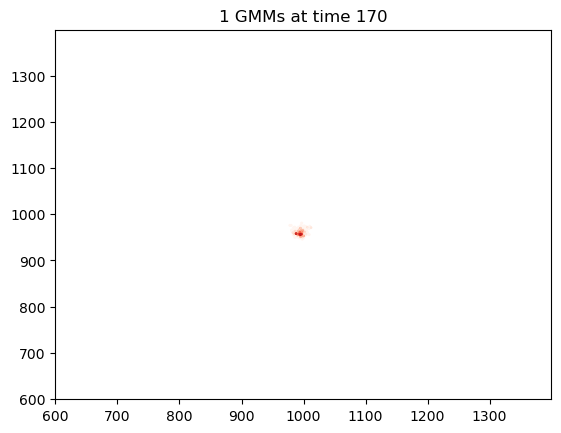

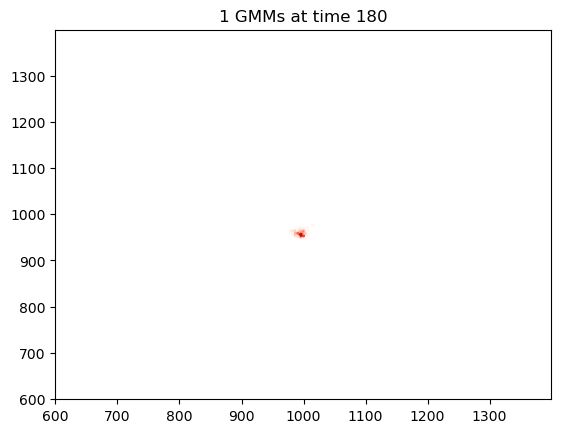

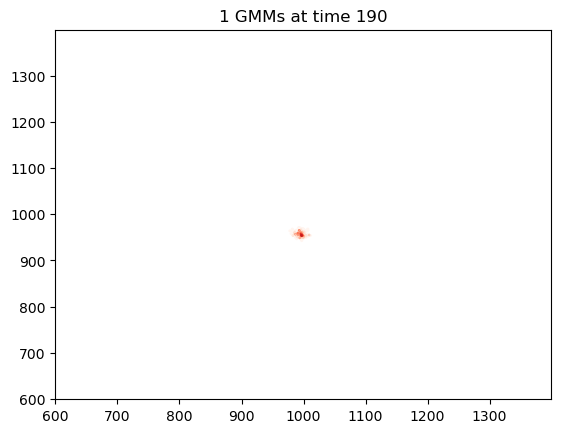

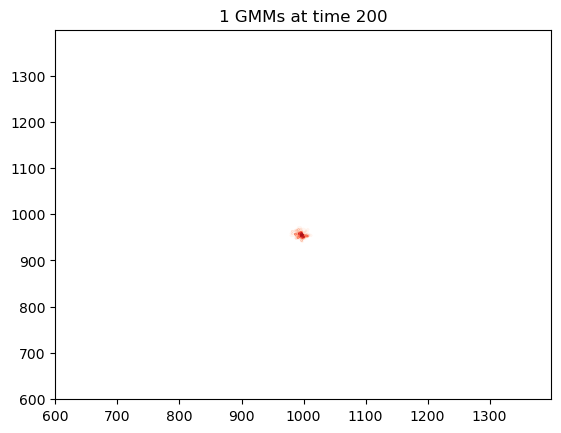

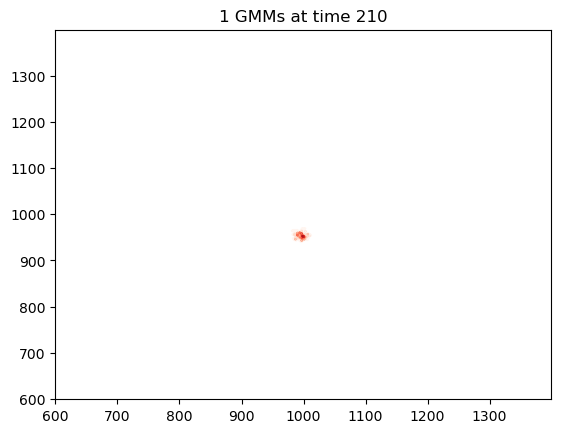

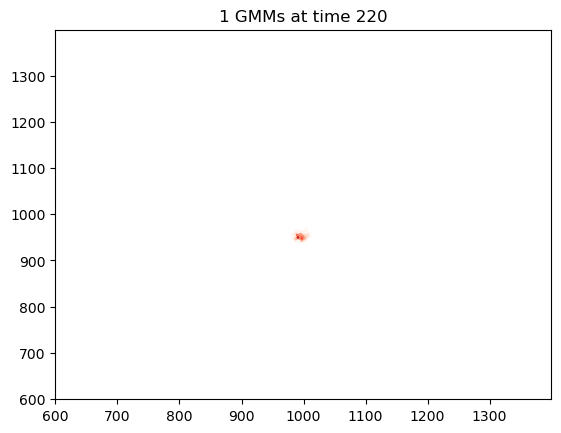

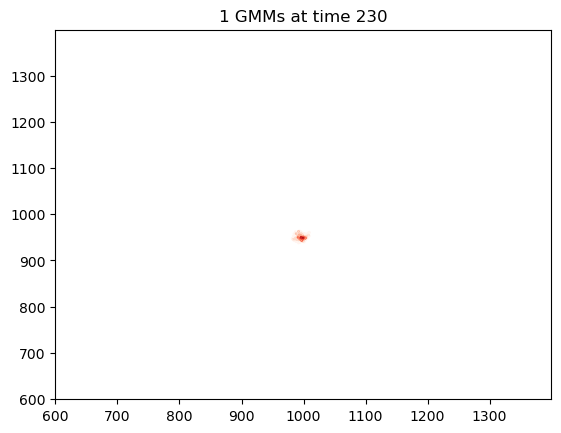

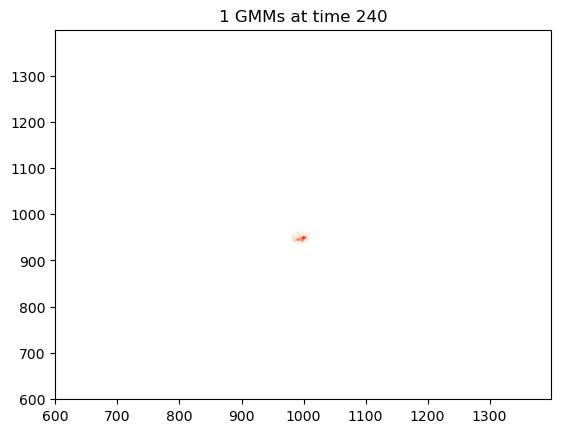

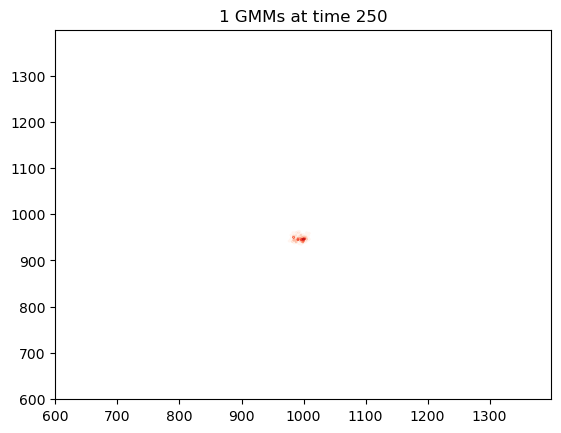

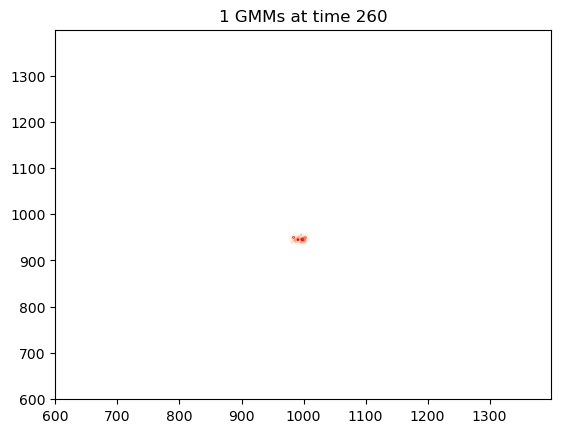

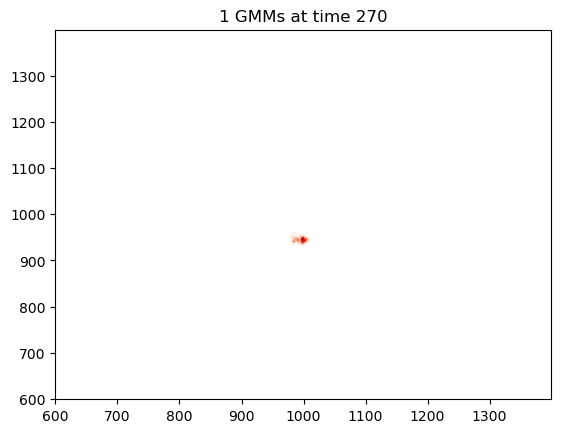

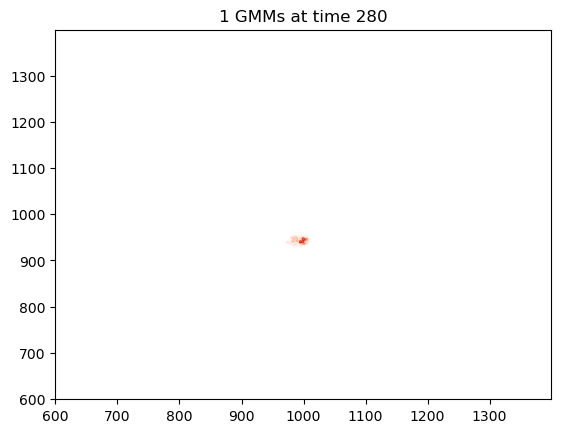

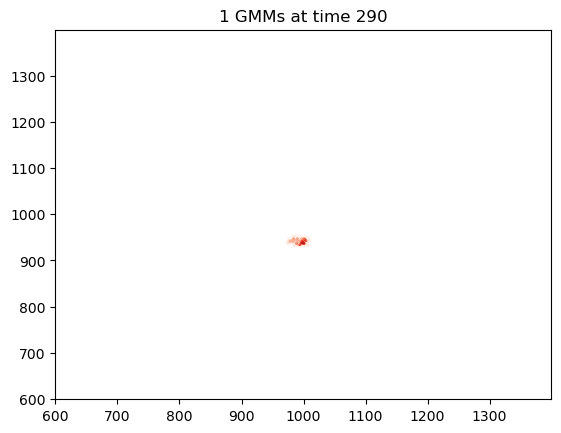

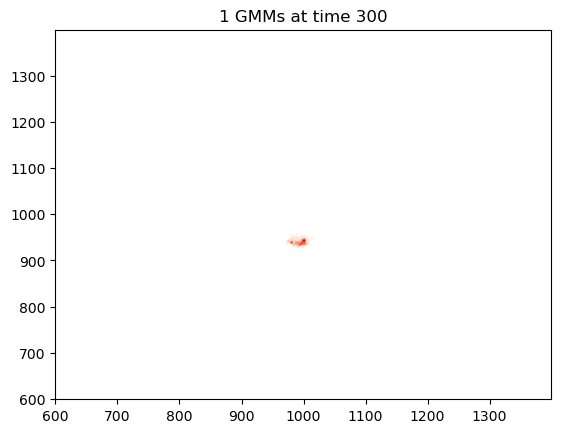

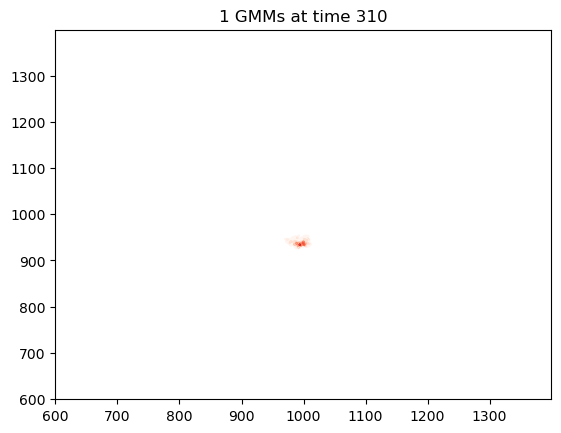

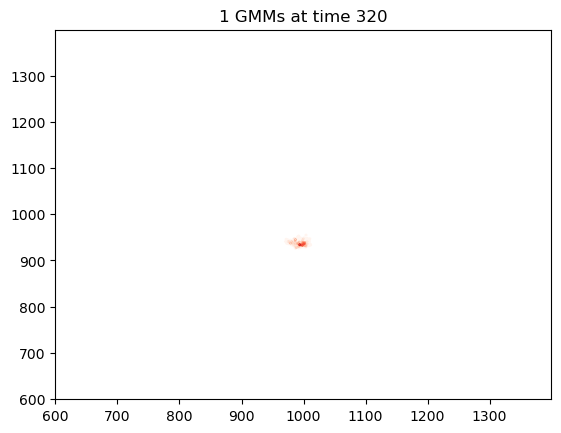

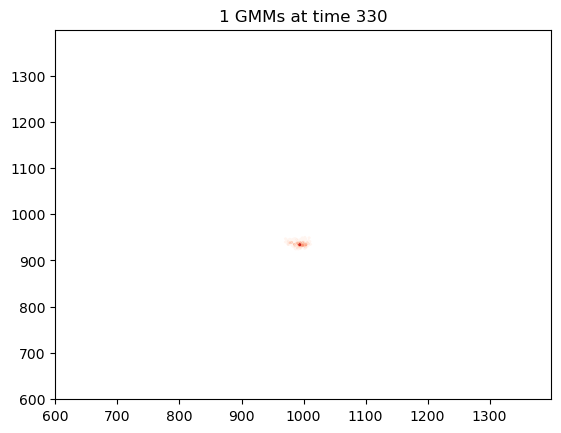

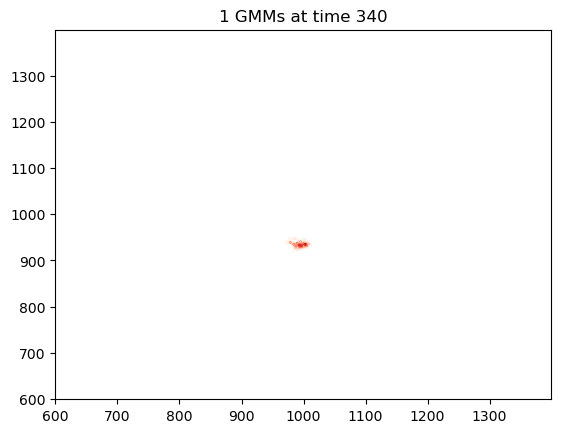

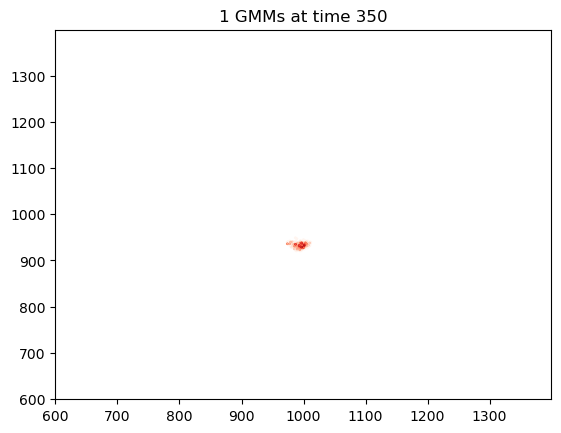

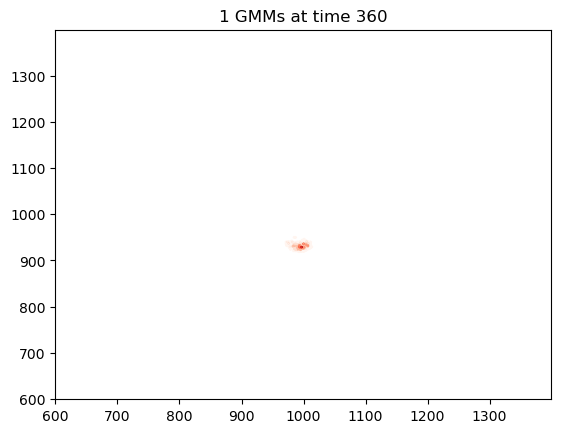

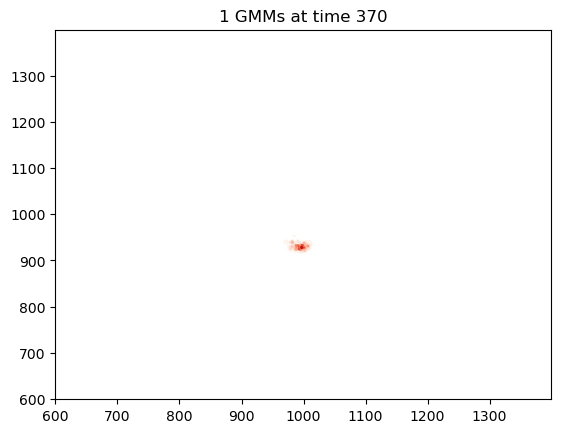

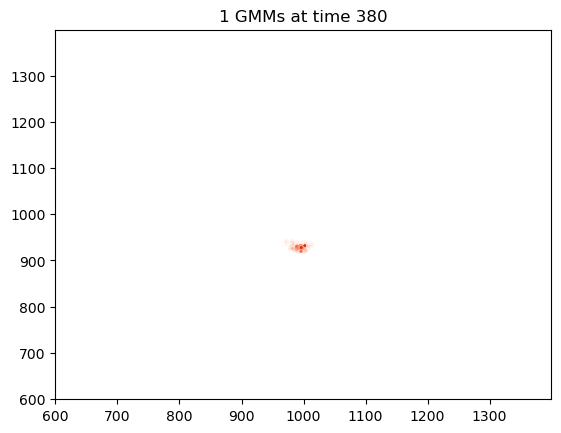

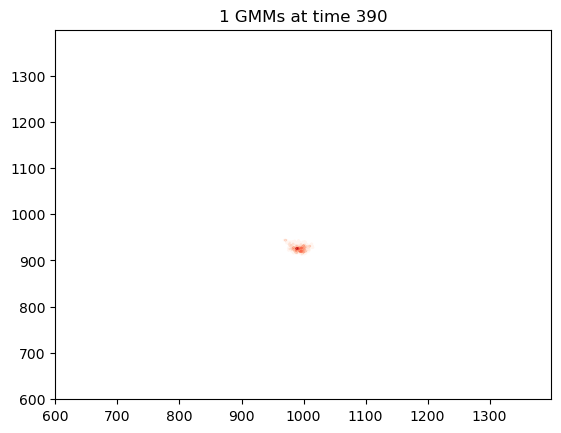

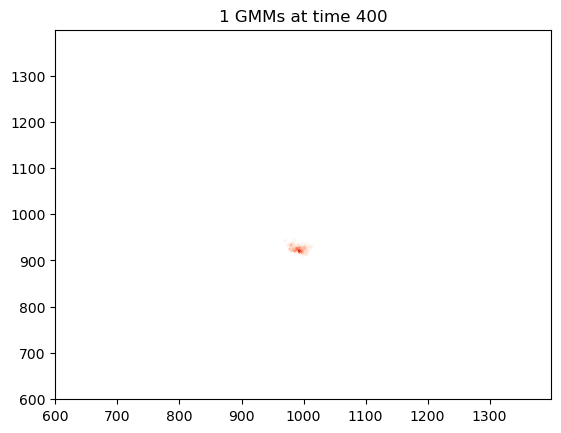

Error in callback <function flush_figures at 0x1643f5300> (for post_execute):


KeyboardInterrupt: 

In [54]:
create_both_Gifs(t_dom, foldername, margins)

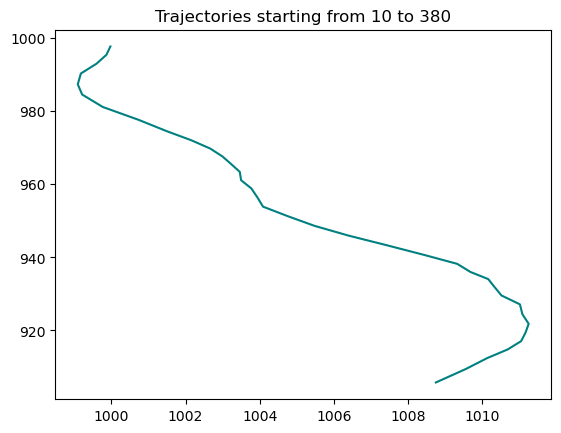

In [18]:
colors = generate_colors(len(init_list))
plt.figure()
plt.title(f"Trajectories starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        try:
            positions = [x.mean for x in trajs]
            x_val, y_val = extract_xy(positions)
            plt.plot(x_val, y_val, color = "teal")
        except IndexError:
            print(positions)

plt.savefig(foldername+ "/trajectories.png")

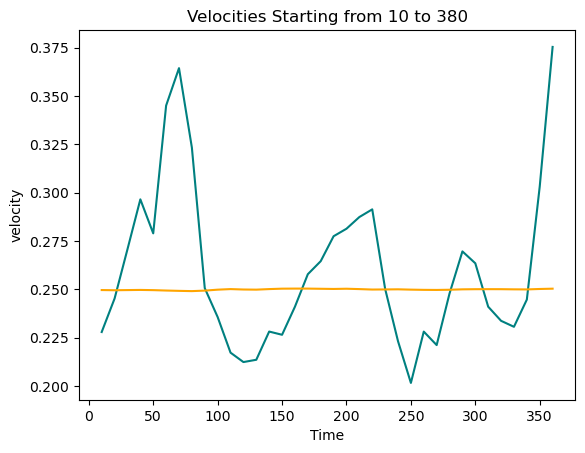

In [19]:
colors = generate_colors(len(init_list))
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        time = [x.frame for x in trajs]
        time_avg = average_of_pairs(time)

        counts = np.array([x.count for x in trajs])
        counts_avg = average_of_pairs(counts)

        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            dt = np.diff(time)
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_calc = calculate_velocity(counts_avg, params, sim_params)
            
            plt.plot(t_domain_np[:len(v_obs)], v_obs, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")
plt.savefig(foldername + "/velocity.png")

Text(0, 0.5, 'velocity')

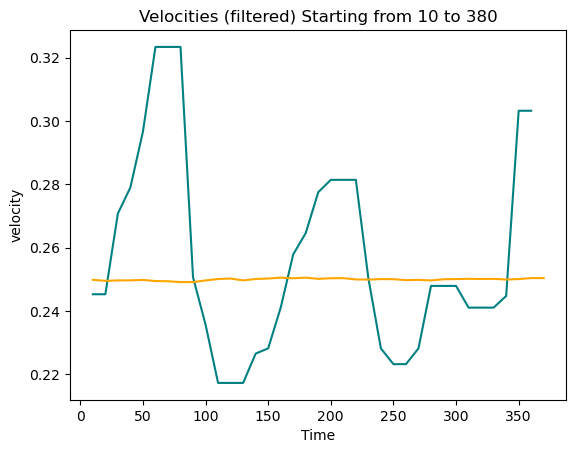

In [20]:
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities (filtered) Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        counts = np.array([x.count for x in trajs])
        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_obs_med = running_median_filter(v_obs, 5)
            v_calc = calculate_velocity(counts, params, sim_params)
            plt.plot(t_domain_np[:len(v_obs_med)], v_obs_med, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")

foldername_itr = []
# betas = [ 0.1, 0.2, 0.5, 0.001, 0.01,]
Nhs = [6, 6.5]
seeds = [0, 1, 2, 3]
for num in Nhs:
    for seed in seeds:
        foldername = f"../Data_Long/Nh{num}_seed{seed}"
        foldername_itr.append(foldername)

for foldername in foldername_itr[1:]:
    with open(foldername + "/params.json") as json_file:
        params = json.load(json_file)
    with open(foldername + "/sim_params.json") as json_file:
        sim_params = json.load(json_file)

    t0 = 1000
    tf = 1200
    dt = 10
    t_domain = np.arange(t0, tf, dt)
    t_domain_new = []

    for t in t_domain:
        try:
            make_frame(foldername, t, save = True, margins=(-0.40, -0.40))
        except FileNotFoundError:
            break
        t_domain_new.append(t)


    make_Gif(foldername, t_domain_new, typename = "time_plots")

    for t in t_domain_new:
        n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
        indexes = get_nonzero_w_repeats(n_i)
        means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes,n_components=1, 
                                                        w = 1000, reg_covar=1e4)
        means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
        plot_Ellipses(n_i, t, means, covs, save = True,
                    foldername = foldername, input_color = "teal", margins=(-0.42, -0.42))

    make_Gif(foldername, t_domain_new, typename = "GMM_plots")

    for t in t_domain_new:
        n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
        indexes = get_nonzero_w_repeats(n_i)
        means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes,n_components=1,
                                                        w = 1000, reg_covar=1e4)
        means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
        next_list = make_Treelist(t, means, covs, counts)
        
        if t == t0:
            init_list = next_list
            prev_list = next_list
            continue

        prev_list = link_Treelists(prev_list, next_list)
        prev_list = next_list

    save_Treelist(foldername, init_list)
    make_Gif(foldername, t_domain_new, typename = "GMM_plots")

    colors = generate_colors(len(init_list))
    plt.figure()
    plt.title(f"Trajectories starting from {t0} to {tf}")

    for root_node, color in zip(init_list, colors):
        for trajs in root_node.get_all_traversals():
            try:
                positions = [x.mean for x in trajs]
                x_val, y_val = extract_xy(positions)
                plt.plot(x_val, y_val, color = "teal")
            except IndexError:
                print(positions)

    plt.savefig(foldername+ "/trajectories.png")

    colors = generate_colors(len(init_list))
    t_domain_np = np.array(t_domain_new)
    plt.figure()
    plt.title(f"Velocities Starting from {t0} to {t_domain_new[-1]}")

    for root_node, color in zip(init_list, colors):
        for trajs in root_node.get_all_traversals():
            positions = [x.mean for x in trajs]
            time = [x.frame for x in trajs]
            time_avg = average_of_pairs(time)

            counts = np.array([x.count for x in trajs])
            counts_avg = average_of_pairs(counts)

            x_val, y_val = extract_xy(positions)
            if isinstance(x_val, np.ndarray):
                dt = np.diff(time)
                v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
                v_calc = calculate_velocity(counts_avg, params, sim_params)
                
                plt.plot(t_domain_np[:len(v_obs)], v_obs, color = 'teal')
                plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

    # plt.ylim(0, 0.2)
    plt.xlabel("Time")
    plt.ylabel("velocity")
    plt.savefig(foldername + "/velocity.png")

In [21]:
t

370